In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.spatial.distance import cdist
import seaborn as sns

## Load data

In [2]:
df = pd.read_csv('../data/spam.csv', encoding='ISO-8859-1')
df['is_spam'] = df['v1'].apply(lambda x: 1 if x == 'spam' else 0)
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'v1'], inplace=True)
df.rename(columns={'v2': 'sentence'}, inplace=True)

In [3]:
df.head()

,sentence,is_spam
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


## Train test split

In [4]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=23)

## Tokenize

In [5]:
tokenizer = Tokenizer(num_words=20_000)
tokenizer.fit_on_texts(df_train['sentence'])

In [6]:
len(tokenizer.word_index)

7271

In [7]:
df_train['sequence'] = tokenizer.texts_to_sequences(df_train['sentence'])
df_test['sequence'] = tokenizer.texts_to_sequences(df_test['sentence'])

## Padding

In [8]:
np.shape(pad_sequences(df_train['sequence']))

(3733, 189)

In [9]:
# Check lengths before padding on train, pad and recheck
print(f"Max seq on train: {df_train['sequence'].apply(len).max()}    Min seq on train: {df_train['sequence'].apply(len).min()}")
print(f"Expected shape lenght after padding: {pad_sequences(df_train['sequence']).shape}")
print(f"df_train shape: {df_train.shape}")
data_train = pad_sequences(df_train['sequence'])
print(f"data_train shape: {np.shape(data_train)}")

# Set max length based on train
MAX_LENGTH = df_train['sequence'].apply(len).max()

# Check lengths before padding on test, pad and recheck
print(f"Max seq on test: {df_test['sequence'].apply(len).max()}    Min seq on test: {df_test['sequence'].apply(len).min()}")
data_test = pad_sequences(df_test['sequence'], maxlen=MAX_LENGTH)
print(f"data_test shape: {np.shape(data_test)}")

Max seq on train: 189    Min seq on train: 1
Expected shape lenght after padding: (3733, 189)
df_train shape: (3733, 3)
data_train shape: (3733, 189)
Max seq on test: 157    Min seq on test: 0
data_test shape: (1839, 189)


## Create LSTM

In [10]:
i = layers.Input(shape=(MAX_LENGTH, ))
x = layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8)(i)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [11]:
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

## Train

In [12]:
r = model.fit(data_train, df_train['is_spam'], epochs=10, validation_data=(data_test, df_test['is_spam']))

Epoch 1/10
117/117 [==============================] - 14s 99ms/step - loss: 0.4335 - acc: 0.8527 - val_loss: 0.3696 - val_acc: 0.8787
Epoch 2/10
117/117 [==============================] - 6s 54ms/step - loss: 0.3895 - acc: 0.8596 - val_loss: 0.3282 - val_acc: 0.8787
Epoch 3/10
117/117 [==============================] - 5s 44ms/step - loss: 0.1990 - acc: 0.9237 - val_loss: 0.1109 - val_acc: 0.9630
Epoch 4/10
117/117 [==============================] - 4s 34ms/step - loss: 0.0482 - acc: 0.9882 - val_loss: 0.0489 - val_acc: 0.9869
Epoch 5/10
117/117 [==============================] - 4s 31ms/step - loss: 0.0256 - acc: 0.9925 - val_loss: 0.0477 - val_acc: 0.9897
Epoch 6/10
117/117 [==============================] - 3s 29ms/step - loss: 0.0181 - acc: 0.9949 - val_loss: 0.0478 - val_acc: 0.9886
Epoch 7/10
117/117 [==============================] - 3s 28ms/step - loss: 0.0111 - acc: 0.9968 - val_loss: 0.0488 - val_acc: 0.9880
Epoch 8/10
117/117 [==============================] - 3s 28ms/step -

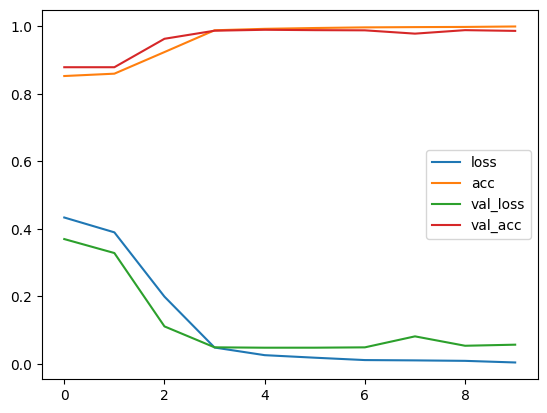

In [13]:
pd.DataFrame(r.history).plot();

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 189)]             0         
                                                                 
 embedding (Embedding)       (None, 189, 8)            58176     
                                                                 
 lstm (LSTM)                 (None, 189, 128)          70144     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 128449 (501.75 KB)
Trainable params: 128449 (501.75 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

## Train v2

In [15]:
i = layers.Input(shape=(MAX_LENGTH, ))
x = layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=8)(i)
x = layers.LSTM(128, return_sequences=False)(x)
#x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [16]:
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [17]:
r = model.fit(data_train, df_train['is_spam'], epochs=10, validation_data=(data_test, df_test['is_spam']))

Epoch 1/10


117/117 [==============================] - 10s 75ms/step - loss: 0.3092 - acc: 0.8942 - val_loss: 0.1165 - val_acc: 0.9744
Epoch 2/10
117/117 [==============================] - 5s 46ms/step - loss: 0.0637 - acc: 0.9829 - val_loss: 0.0500 - val_acc: 0.9848
Epoch 3/10
117/117 [==============================] - 5s 38ms/step - loss: 0.0343 - acc: 0.9904 - val_loss: 0.0484 - val_acc: 0.9875
Epoch 4/10
117/117 [==============================] - 3s 30ms/step - loss: 0.0178 - acc: 0.9952 - val_loss: 0.0546 - val_acc: 0.9875
Epoch 5/10
117/117 [==============================] - 3s 29ms/step - loss: 0.0094 - acc: 0.9976 - val_loss: 0.0651 - val_acc: 0.9848
Epoch 6/10
117/117 [==============================] - 4s 30ms/step - loss: 0.0058 - acc: 0.9989 - val_loss: 0.0613 - val_acc: 0.9875
Epoch 7/10
117/117 [==============================] - 3s 26ms/step - loss: 0.0044 - acc: 0.9987 - val_loss: 0.0516 - val_acc: 0.9880
Epoch 8/10
117/117 [==============================] - 3s 27ms/step - loss: 0.01

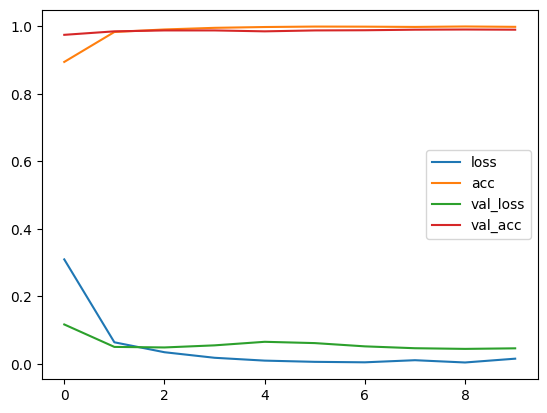

In [18]:
pd.DataFrame(r.history).plot();

In [19]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 189)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 189, 8)            58176     
                                                                 
 lstm_1 (LSTM)               (None, 128)               70144     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 128449 (501.75 KB)
Trainable params: 128449 (501.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Get most similar words

In [20]:
# Retrieve the embedding layer from the model
embedding_layer = model.get_layer("embedding_1")

# Get the learned word embeddings
embeddings = embedding_layer.get_weights()[0]

# Calculate the pairwise cosine similarity between all word embeddings
cosine_similarities = np.dot(embeddings, embeddings.T) / (np.linalg.norm(embeddings, axis=1) * np.linalg.norm(embeddings.T, axis=0))

# Set the diagonal elements to a very low value to avoid selecting the same word
np.fill_diagonal(cosine_similarities, -1.0)

# Find the indices of the most similar pair
most_similar_indices = np.unravel_index(np.argsort(cosine_similarities, axis=None)[-1], cosine_similarities.shape)

In [21]:
# Retrieve the most similar pair of words
tokenizer.index_word[most_similar_indices[0]], tokenizer.index_word[most_similar_indices[1]]

('my', 'sections')

In [22]:
np.shape(embeddings)

(7272, 8)

In [23]:
embeddings[0]

array([ 0.03613682, -0.00971434,  0.02370286, -0.00311136,  0.00753672,
       -0.03858561, -0.00422123, -0.02676945], dtype=float32)

In [24]:
embeddings[1]

array([ 0.1226817 , -0.15503135,  0.12223896,  0.1195395 , -0.0935009 ,
       -0.15362728,  0.07021676,  0.13650054], dtype=float32)

In [25]:
np.shape(cdist(embeddings, embeddings, metric='euclidean'))

(7272, 7272)

In [26]:
np.shape(cosine_similarities)

(7272, 7272)